# Read all the hap.py vcfs and compute overlaps

Needs an environment with pyvcf and other anaconda packages.

Because it needs pyvcf, the dependencies dictate that it will have an older version of seaborn and others.

In [8]:
import vcf
import vcf.utils
import glob
import re
import pandas as pd
import upsetplot
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

## Read metadata

In [9]:
paths = glob.glob("d50_variant_analysis/*/*vcf.gz")

In [10]:
names, kits, concs, replicates = zip(*[
    re.match(r".*/(([A-Za-z0-9]+)-(\d+ng)-(\d))\.vcf\.gz", path).groups()
    for path in paths
])

## Data frame for metadata summary

In [11]:
df = pd.DataFrame({'Name': names, 'Kit': kits, 'Conc': concs, 'Replicate': replicates, 'Path': paths})

In [12]:
df.head()

,Name,Kit,Conc,Replicate,Path
0,NEB-10ng-1,NEB,10ng,1,d50_variant_analysis/NEB-10ng-1_happy/NEB-10ng...
1,NEB-10ng-3,NEB,10ng,3,d50_variant_analysis/NEB-10ng-3_happy/NEB-10ng...
2,Quanta-100ng-2,Quanta,100ng,2,d50_variant_analysis/Quanta-100ng-2_happy/Quan...
3,Swift2S-100ng-4,Swift2S,100ng,4,d50_variant_analysis/Swift2S-100ng-4_happy/Swi...
4,Nextera-10ng-3,Nextera,10ng,3,d50_variant_analysis/Nextera-10ng-3_happy/Next...


### Only analyse 100 ng data

In [13]:
# af = analysis data frame
af = df[(df.Conc=='100ng')&(df.Kit!="Swiftlong")].copy()

In [14]:
kits = list(set(af.Kit))
print(kits)
print(kits[-10:])

['NEB', 'Swift2S', 'Quanta', 'Nextera', 'Kapa']
['NEB', 'Swift2S', 'Quanta', 'Nextera', 'Kapa']


### Find quality cut-offs for picking N true positives

In [16]:
# Nextera @ QQ>-5: 11269522
N = 4_000_000
N2 = 3_000_000
nbatch = 10000
q_cuts = []
q_n2 = []
i=0
for kit in kits:
    #break # Skip this loop -- computed values for normalisation mode "d" given below
    readers = [vcf.Reader(filename=path) for path in af[af.Kit==kit].Path]
    print("Analysing", len(readers), "files for kit", kit, ".")
    qvals = np.array([])
    ibatch = 0
    n_rows = 0
    batch = np.zeros(nbatch)
    for variants in vcf.utils.walk_together(*readers):
        n_rows += 1
        if any(var.samples[0].data.BVT == 'SNP' for var in variants if var):
            replicates_qvals = sorted([var.samples[1].data.QQ for var in variants
                     if var and var.samples[1].data.BD=='TP'])
            if len(replicates_qvals) > 2:
                batch[ibatch] = replicates_qvals[-3]
                ibatch += 1
                if ibatch == nbatch:
                    ii = np.searchsorted(qvals, batch)
                    qvals = np.insert(qvals, ii, batch)[-(N+1):]
                    ibatch = 0
    ii = np.searchsorted(qvals, batch[0:ibatch])
    qvals = np.insert(qvals, ii, batch[0:ibatch])[-(N+1):]
    print('Kit', kit, ' - Processed', n_rows, 'rows.')
    print('Kit', kit, 'QQ >', qvals[0], "(", len(qvals)-1, " variants)")
    q_cuts.append(qvals[0])
    if len(qvals) > N2+1:
        print('Kit', kit, 'QQ >', qvals[-(N2+1)], "(", N2, "variants)")
        q_n2.append(qvals[-(N2+1)])

Analysing 4 files for kit NEB .


KeyboardInterrupt: 

In [9]:
qq_cuts_dict = {}
qq_cuts_dict['Kapa'] = -1.6
qq_cuts_dict['NEB'] = -1.595
qq_cuts_dict['Swift2S'] = -1.603
qq_cuts_dict['Nextera'] = -2.308
qq_cuts_dict['Quanta'] = -1.998

## Make a place to hold the counts

`group_combinations`

| Truth | Type  | Value |
|-------|-------|-------|
| True  | SNP   | Series counts |
| False | SNP   | Series counts |
| True  | INDEL | Series counts |
| False | INDEL | Series counts |

Series counts are series containing the counts of each combination of callers. The indexes are MultiIndexes with one level for each kit, with value True if the variant is called, False otherwise.

In [10]:
group_counts_idx = pd.MultiIndex.from_product([[True,False] for _ in kits], names=kits)
types = ['SNP', 'INDEL'] # May need to refactor if we're to separate indel types

In [11]:
kits

['Swift2S', 'Nextera', 'NEB', 'Quanta', 'Kapa']

## VCF Reading loop

In [12]:
kits_readers = [(row.Kit, vcf.Reader(filename=row.Path)) for _, row in af.iterrows()]
kits_in_order, readers = zip(*kits_readers)

print(list(kits_in_order))

abort = 12000000
#abort = 200000000

group_combinations = {
    (truth, typ): pd.Series(index=group_counts_idx, dtype='uint32')
    for typ in types
    for truth in [True, False]
    }
intra_kit_consensus = {kitname: [0, 0, 0, 0, 0] for kitname in kits}

tp_counters = [0] * len(readers)
n_kap_ctr = 0
for variants in vcf.utils.walk_together(*readers):
    if abort == 0:
        break
    else:
        abort -= 1
        if abort % 100000 == 0:
            print("kapa variants TP found", n_kap_ctr)
            print(abort, "variants remaining...")
            
    is_true = (variants[0] and variants[0].samples[0].data.BD in ['TP', 'FN']) == True
    
    if not is_true:
        for var in variants:
            if var and var.samples[0].data.BD == 'TP':
                print("WTFingF?", var.CHROM, var.POS)
                raise WTF
    
    typ = next(iter(
        vcall.samples[isam].data.BVT
        for vcall in variants
        for isam in [0,1]
        if vcall and vcall.samples[isam].data.BVT != 'NOCALL'
    ))
    
    var_group_counts = [0] * len(kits)
    for vcall, kit in zip(variants, kits_in_order):
        if vcall:
#            if vcall.samples[1].data.BD == 'TP' and vcall.samples[1].data.QQ > qq_cuts_dict[kit]:
            if vcall.samples[1].data.BD == 'TP' and vcall.samples[1].data.QQ > -5:
                var_group_counts[kits.index(kit)] += 1
    
    if is_true:
        for i, kit in enumerate(kits):
            intra_kit_consensus[kit][var_group_counts[i]] += 1
            
    combinations_index = tuple(x > 2 for x in var_group_counts)
    if is_true and combinations_index[0]: n_kap_ctr+=1
    
    group_combinations[(is_true, typ)][combinations_index] += 1


['Quanta', 'Swift2S', 'Swift2S', 'Quanta', 'Quanta', 'Quanta', 'Swift2S', 'Swift2S', 'Kapa', 'Nextera', 'NEB', 'Kapa', 'Nextera', 'NEB', 'Nextera', 'NEB', 'Kapa', 'NEB', 'Kapa', 'Nextera']
kapa variants TP found 38981
11900000 variants remaining...
kapa variants TP found 84175
11800000 variants remaining...
kapa variants TP found 125033
11700000 variants remaining...
kapa variants TP found 144640
11600000 variants remaining...
kapa variants TP found 190962
11500000 variants remaining...
kapa variants TP found 236566
11400000 variants remaining...
kapa variants TP found 282495
11300000 variants remaining...
kapa variants TP found 317108
11200000 variants remaining...
kapa variants TP found 360368
11100000 variants remaining...
kapa variants TP found 407983
11000000 variants remaining...
kapa variants TP found 455311
10900000 variants remaining...
kapa variants TP found 496917
10800000 variants remaining...
kapa variants TP found 544842
10700000 variants remaining...
kapa variants TP fou

### Total counts

In [18]:
for typ in ['SNP', 'INDEL']:
    truecalls = group_combinations[(True, typ)]
    for kit in kits:
        print(f"kit {kit:9}  - Total true {typ} :", truecalls[truecalls.index.get_level_values(kit)].sum())

kit Swift2S    - Total true SNP : 2727549
kit Nextera    - Total true SNP : 2699814
kit NEB        - Total true SNP : 2739201
kit Quanta     - Total true SNP : 2721661
kit Kapa       - Total true SNP : 2714794
kit Swift2S    - Total true INDEL : 346279
kit Nextera    - Total true INDEL : 319710
kit NEB        - Total true INDEL : 356478
kit Quanta     - Total true INDEL : 351014
kit Kapa       - Total true INDEL : 358350


### Experimental colouring by true/false

In [ ]:
# Make TP/FP in single data frame
group_data = {}
for typ in ['SNP', 'INDEL']:
    group_data[typ] = pd.concat([
        pd.DataFrame({'Count': group_combinations[(truth, 'SNP')]}).assign(Truth=truth)
        for truth in [True, False]
    ])

In [ ]:
#upsetplot.plot(group_combinations.drop(tuple([0]*len(kits))).drop(tuple([1]*len(kits))), sort_by='cardinality')
up = upsetplot.UpSet(
    group_data['SNP'].drop(tuple([False]*len(kits))),
    sort_by='cardinality',
    sort_categories_by=None,
    sum_over='Count'
)

In [ ]:
totales_orig_save = upsetplot.UpSet.plot_totals

In [ ]:
def plot_totals_mar(self, ax, hue):
    """Plot bars indicating total set size
    """
    orig_ax = ax
    ax = self._reorient(ax)
    recst = sns.barplot()
    rects = ax.barh(np.arange(len(self.totals.index.values)), self.totals,
                    .5, color=self._facecolor, align='center')
    self._label_sizes(ax, rects, 'left' if self._horizontal else 'top')

    max_total = self.totals.max()
    if self._horizontal:
        orig_ax.set_xlim(max_total, 0)
    for x in ['top', 'left', 'right']:
        ax.spines[self._reorient(x)].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    ax.patch.set_visible(False)


In [ ]:
up.add_stacked_bars('Truth', sum_over='Count', elements=6)
print(up._subset_plots)
up._subset_plots.pop(0)
f = plt.figure()
up.plot_shading(plt.axes())

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(group_data['SNP'])

In [ ]:
group_combinations[(True,'SNP')].sum()

### Normal plot for true/false positives separately

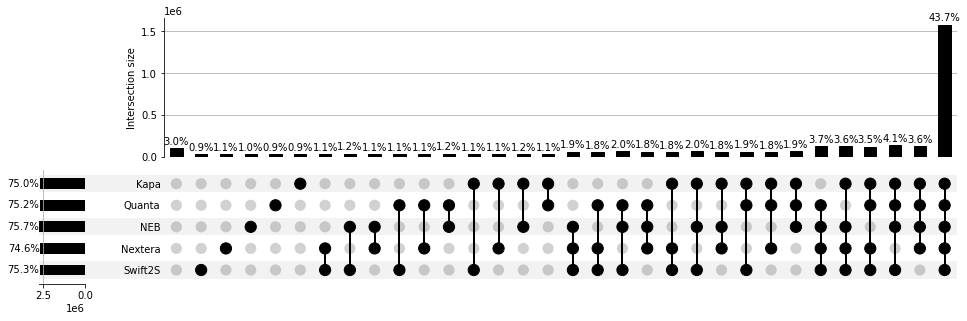

In [26]:
up = upsetplot.UpSet(group_combinations[(True,'SNP')], sort_by='degree', sort_categories_by=None, show_percentages=True)
frames = up.plot()
#frames['intersections'].set_ylim(0, group_combinations[(True, 'SNP')][(False, True, True, True, True)] * 1.1)

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fb526fe5da0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fb525a92518>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fb527051208>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fb527090b00>}

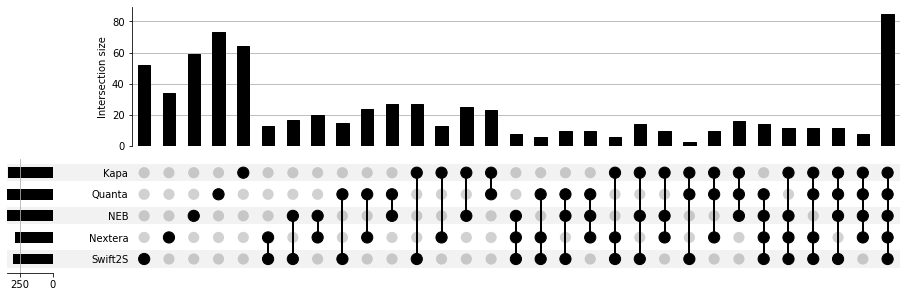

In [27]:
upsetplot.plot(group_combinations[(False,'SNP')].drop(tuple([0]*len(kits))), sort_by='degree', sort_categories_by=None)

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fb525bffac8>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fb5261f2ac8>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fb526853a58>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fb5268aafd0>}

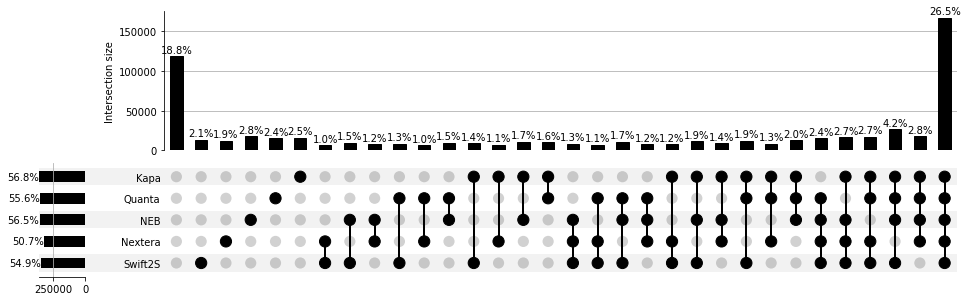

In [25]:
upsetplot.plot(group_combinations[(True, 'INDEL')], sort_by='degree', sort_categories_by=None, show_percentages=True)

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7fb525c16550>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7fb525c230b8>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7fb5259bf240>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7fb5261dfdd8>}

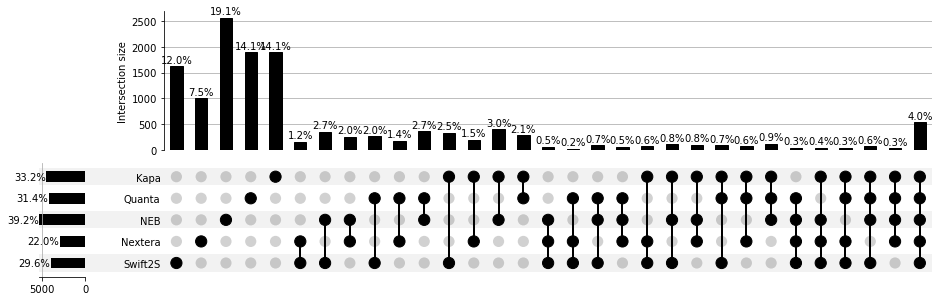

In [24]:
upsetplot.plot(group_combinations[(False, 'INDEL')].drop(tuple([0]*len(kits))), sort_by='degree', sort_categories_by=None, show_percentages=True)

## Test / experimenting

In [ ]:
subplots = upsetplot.plot(group_combinations[(True, 'INDEL')].drop(tuple([0]*len(kits))), sort_by='cardinality', sort_categories_by=None, min_degree=4)
subplots['intersections'].set_yscale('log')

In [ ]:
intra_kit_consensus

In [ ]:
kit_numreplicates_trueposcount = [
    (kit, num_replicates_called, intra_kit_consensus[kit][num_replicates_called])
    for num_replicates_called in [0,1,2,3,4]
    for kit in kits
]

In [ ]:
iccdf = pd.DataFrame(data=kit_numreplicates_trueposcount, columns=['Kit', 'NumReplicatesHave', 'NumTpCalls'])

In [ ]:
sns.barplot(data=iccdf, x='NumReplicatesHave', y='NumTpCalls', hue='Kit')

## Export data to csv

In [20]:
dataframes = []
for (truth, typ) in [(True, 'SNP'), (True, 'INDEL'), (False, 'SNP'), (False, 'INDEL')]:
    part_df = group_combinations[(truth, typ)].reset_index().rename(columns={0: 'Count'})
    part_df['Truth'] = truth
    part_df['Type'] = typ
    dataframes.append(part_df)
full_df = pd.concat(dataframes)
# Uncomment this to write / overwrite the file
#full_df.to_csv('overlap-variant-data.csv', index=False)
full_df.head(n=1)

,Swift2S,Nextera,NEB,Quanta,Kapa,Count,Truth,Type
0,True,True,True,True,True,1580858,True,SNP


# Load exported data

In [ ]:
full_df = pd.read_csv('overlap-data-all-d.csv')
group_combinations2 = {}
for (truth, typ) in [(True, 'SNP'), (True, 'INDEL'), (False, 'SNP'), (False, 'INDEL')]:
    part_df = full_df.loc[(full_df.Type==typ)&(full_df.Truth==truth)].set_index(kits)
    group_combinations2[(truth, typ)] = part_df.Count

print(group_combinations2[(True, 'SNP')].head(n=1))

In [ ]:
# Uncomment this to load from file 
#group_combinations = group_combinations2

# Testing / Experiment

In [ ]:
løk = pd.DataFrame(
    {
        #'Kit': ['Nextera', 'NEB', 'Nextera', 'NEB', 'Nextera', 'NEB'],
        'Nextera': [True, True, True, False, False, True],
        'NEB':   [ False, True, True, False, False, True],
        'Type':  ['SNP','SNP','SNP','INDEL','SNP','SNP']
    }
).set_index(['Nextera', 'NEB'])
up = upsetplot.UpSet(løk)
up.add_stacked_bars('Type')
up.plot()

In [ ]:
plt.subplots(2, 2)

In [ ]:
(fig, (tops, bots)) = plt.subplots(2, 2)
up2 = upsetplot.UpSet(løk)
up2.plot_matrix(bots[1])
up2.add_stacked_bars('Type')

# SNP count double check with bcftools

In [ ]:
af_names = list(os.path.basename(p).replace(".vcf.gz","") for p in af.Path)
print(" ".join(af_names))

In [ ]:
af['bcftoolsTpCount'] = [int(open(f"tmp-snpcounts/tp-{n}.txt").read().strip()) for n in af_names]
af['bcftoolsFpCount'] = [int(open(f"tmp-snpcounts/fp-{n}.txt").read().strip()) for n in af_names]
print(af.groupby("Kit").bcftoolsTpCount.sum())
print(af.groupby("Kit").bcftoolsFpCount.sum())
print(af.groupby("Kit").apply(lambda row: row.bcftoolsTpCount.sum() / (row.bcftoolsTpCount.sum() + row.bcftoolsFpCount.sum())))